In [907]:
import geopy
from geopy.extra.rate_limiter import RateLimiter


import pandas as pd
import numpy as np
import geopandas as gpd

from matplotlib import pyplot as plt
import shapely

%matplotlib inline

import contextily as ctx
import requests
import plotly.express as px
from zipfile import ZipFile
import json
import random
import os, urllib
import seaborn as sbn

#from tqdm.auto import tqdm, trange
from tqdm import tqdm, trange
tqdm.pandas()

from geopy_nominatim_wrapper import NominatimWrapper
from geopy_bestaddress import BestAddress
from geopy_pelias import Pelias
from geopy_ngipelias import NGIPelias


from credentials import (here_api_key, 
                         bing_api_key, 
                         mapbox_api_key, 
                         tomtom_api_key, 
                         google_api_key, 
                         best_client_id, best_client_secret, best_hostname)



fig_path = "output/geocoding/figs"
data_dir = "data/geocoding"
output_dir="output/geocoding/"
# from fpdf import FPDF 

In [908]:
# dataset = "rrn_1000"
dataset = "kbo_1000"
# dataset = "best_1000"
# dataset = "best2_1000"
# dataset = "rep_1000"
# dataset = "resto_1000"

# dataset = "kbo_10000"
# dataset = "rrn_10000"
dataset = "rep_10000"


In [909]:
crs =     'epsg:3857'
osm_crs=  'epsg:4326'

In [910]:
def_figsize = (10,8)

In [911]:
os.makedirs(f"{output_dir}/geocoded_data/", exist_ok=True)
os.makedirs(f"{output_dir}/reports/", exist_ok=True)
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)


In [912]:
def add_basemap(ax, zoom='auto'):
    """
    Add a basemap on a plot. Tries first default (Stamen) basemap. If errors, tries OpenStreetMap.Mapnik
    
    Parameters
    ----------
    ax: matplotlib axes
    
    Returns
    -------
        None
    """

    try: 
#         ctx.add_basemap(ax, zoom=zoom)
#     except requests.HTTPError:
#         print("Default basemap doesn't work...")
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
    except ValueError as e:
        print("Value error...")
        print(e)

In [913]:
def set_optimal_limits(ax, df):
    """
    Adapt xlim/ylim to a GeoDataFrame point plot to avoid plot to be too wide when 
    points are horizontally aligned, and to narrow when points are vertically aligned

    Usage : 
    
    ax = df.plot()
    set_optimal_limits(ax, df)
    
    Parameters
    ----------
    ax: AxesSubplot
       plot to resize
    df: GeoDataFrame
       data to be plotted

    Returns
    -------
        None
    """
    
    plot_ratio = 1.5 # optimal ratio between "one horizontal degree" and "one vertical degree". It depends of the CRS. 
                     # For "polar" CRS, it may also depend of the place on the globe

    minimal_width=200
   
    margins = 1.1 # Avoid having dots on edges of the plot
    

    # Compute dimension of the data
    xmin, ymin, xmax, ymax = df.total_bounds
    height = (ymax - ymin) 
    width = (xmax - xmin)
    
    opt_height = max(height, width / plot_ratio, minimal_width / plot_ratio)
    opt_width  = max(width , height*plot_ratio, minimal_width)
    
#     print(xmin, ymin, xmax, ymax)
#     print(width, height, opt_width, opt_height)
    # If plot is too narrow, increase xmin. If plot is too wide, increase ylim

    if opt_height > height :
        ymid = (ymax+ymin)/2
        mid_height = opt_height * margins / 2
        ax.set_ylim(ymid - mid_height, ymid + mid_height)
    if opt_width > width:
        xmid = (xmax+xmin)/2
        mid_width = opt_width* margins/2
        ax.set_xlim(xmid - mid_width, xmid + mid_width)

In [914]:
def pdf_savefig():
    try: 
        pdf.savefig(bbox_inches='tight')
    except AttributeError:
        print("PDF probably closed")

In [915]:
# plot_address(geocoded_data, geocoded_data.iloc[5].address)

# Prepare geocoders

In [916]:
def get_precision(record):
    
    precision_field= {
        "nominatim": "class",
        "nominatim_loc": "class",
        "nominatim_wrapper": ("metadata", "placeRank"),
#         "nominatim_wrapper2": "place_rank",
        "here": "MatchLevel",
        "photon": ("properties", "type"),
        "bing": "entityType",
        "mapbox": ("properties", "accuracy"),
        "tomtom": "type",
        "trillium": "match_level",
        "google":("geometry", "location_type"),
        "bestaddress": "precision",
        "lpost_bestaddress": "precision"
    }
    
    label_mapping = {
        "nominatim": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
                      
                      
        "nominatim_loc": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
        
        "nominatim_wrapper": {"30": "building", 
                              "27": "street",
                              "26": "street",
                              "25": "city",
                              "22": "city",
                              "21": "city",
                              "20": "city",
                              "19": "city",
                              "18": "city",
                              "16": "city",
                              "14": "city"},

        "here": {"houseNumber": "building",
                "street": "street",
                "city": "city",
                "postalCode": "city"},
        "photon": {
            "house": "building",
            "locality": "city",
            "district": "city",
            "city": "city",
            "street": "street"},
        "bing": { "Address": "building",
                  "RoadBlock": "street",
                 "PopulatedPlace": "city",
                 "Postcode1": "city",
                 "CountryRegion": "country"
                },
        "mapbox": {"rooftop": "building",
                   "point": "building",
                   "interpolated": "building",
                  "street": "street"},
        
        "tomtom": {"Point Address": "building",
                  "Street": "street",
                  "Address Range": "street",
                  "Cross Street": "street",
                  "Geography": "city"},
        "trillium": {0:"building",
                      2: "city",
                      3: "street"},
        "google" : {
            "ROOFTOP": "building",
            "RANGE_INTERPOLATED": "building",
            "GEOMETRIC_CENTER": "street",
            "APPROXIMATE": "city"
        },
        "bestaddress":{
            "building": "building",
            "street":"street",
            "country": "country",
            "city":"city"
        },
        "lpost_bestaddress":{
        "building": "building",
        "street":"street",
        "country": "country"
        }
    }
    
    if "pelias" in record.geocoder:
        
        if record.location.point == geopy.Point(0,0):
            return "country"
        
        raw_label = record.location.raw["properties"]
        
        if (raw_label["match_type"] in ["exact", "interpolated"] or raw_label["accuracy"]=="point") and 'housenumber' in raw_label:
            return "building"
        if "street" in raw_label:
            return "street"
        if "region" in raw_label:
            return "city"
        return "country"
    
    if "jcd" in record.geocoder:
        
        if record.location.point == geopy.Point(0,0):
            return "country"
        return "building"
        
    
    try: 
        f = precision_field[record.geocoder]
        mapper = label_mapping[record.geocoder]
        if isinstance(f, str):
            raw_label = record.location.raw[f]
        else: 
            raw_label =  record.location.raw[f[0]][f[1]]
        return mapper[raw_label] if raw_label in mapper else f"[UNKNOWN - {raw_label}]"
    except KeyError: 
        if record.geocoder == "mapbox":
            return "city"
        return "[UNKNOWN]"
    
    

In [917]:
geocoders = {}

In [918]:
from geopy.geocoders import Nominatim
geocoders['nominatim'] = Nominatim(user_agent="smalsresearch", domain="172.27.0.64:8080", scheme="http", timeout=1000)
# geocoders['nominatim'] = Nominatim(user_agent="smalsresearch")


In [919]:
geocoders['nominatim_wrapper'] = NominatimWrapper(user_agent="smalsresearch", scheme="http", timeout=1000, domain="172.27.0.64:5000")

In [920]:
geocoders['bestaddress'] = BestAddress(user_agent="smalsresearch", scheme="https", timeout=1000, 
                                       client_id=best_client_id, client_secret=best_client_secret,
                                       domain=best_hostname,
                                       verbose=False
                                      )

In [921]:
# from geopy.geocoders import Pelias
geocoders['pelias']        = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)
geocoders['pelias_struct'] = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)


In [922]:
geocoders['ngi_pelias_basic'] = NGIPelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
#                                     mode="simple")
                                    mode="basic")


In [923]:
geocoders['ngi_pelias_simple'] = NGIPelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
                                    mode="simple")


In [924]:
geocoders['ngi_pelias'] = NGIPelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
#                                     mode="simple")
                                    mode="advanced")


In [925]:
from geopy.geocoders import Here
geocoders['here'] = Here(apikey=here_api_key)

In [926]:
from geopy.geocoders import Bing
geocoders['bing'] = Bing(api_key=bing_api_key)

In [927]:
from geopy.geocoders import Photon
# geocoders['photon'] = Photon(domain="photon.komoot.io")

geocoders['photon'] = Photon(domain="127.0.0.1:2322", scheme="http")

# geocoders['photon'].geocode("Avenue Fonsny 20, 1060 Bruxelles").raw

In [928]:
from geopy.geocoders import MapBox
geocoders['mapbox'] = MapBox(api_key=mapbox_api_key)

In [929]:
from geopy.geocoders import TomTom
geocoders['tomtom'] =TomTom(api_key=tomtom_api_key)

In [930]:
from geopy.geocoders import GoogleV3
geocoders["google"] = GoogleV3(api_key=google_api_key)

In [931]:
from matplotlib.backends.backend_pdf import PdfPages


# Load data


In [932]:
data = pd.read_csv(f"{data_dir}/{dataset}.csv.gz", dtype=str)

mandatory_columns = ["street", "housenumber", "postcode", "city"]
for f in mandatory_columns:
    assert f in data, f"Field {f} is mandatory !!"


In [933]:
data["address"] = data.street.fillna("")+", "+data.housenumber.fillna("")+", "+data.postcode+" "+data.city+", Belgique"
data

street housenumber postcode                 city  \
0                de Burburelaan          46     1970      Wezembeek-Oppem   
1               Nachtegalenlaan          35     1950             Kraainem   
2                 Rue Tilia(ST)          12     6511             Beaumont   
3                Rue du Hock(N)          36     4121               Neupré   
4               Wuustwezelseweg          95     2990           Wuustwezel   
...                         ...         ...      ...                  ...   
9995        Pavé de Warquignies         108     7340          Colfontaine   
9996       Gillès de Pélichylei         150     2970              Schilde   
9997  Rue de l'Hospice Communal          35     1170  Watermael-Boitsfort   
9998          Rue Saint-Nicolas         616     4000                Liège   
9999                   Oostlaan           4     8560             Wevelgem   

                                                address  
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...  
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique  
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique  
3             Rue du Hock(N), 36, 4121 Neupré, Belgique  
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique  
...                                                 ...  
9995  Pavé de Warquignies, 108, 7340 Colfontaine, Be...  
9996  Gillès de Pélichylei, 150, 2970 Schilde, Belgique  
9997  Rue de l'Hospice Communal, 35, 1170 Watermael-...  
9998       Rue Saint-Nicolas, 616, 4000 Liège, Belgique  
9999               Oostlaan, 4, 8560 Wevelgem, Belgique  

[10000 rows x 5 columns]

In [934]:
data = data.reset_index().rename(columns={"index": "reference_key"})

In [935]:
# data

In [936]:
pdf = PdfPages(f"output/geocoding/reports/report_{dataset}.pdf")

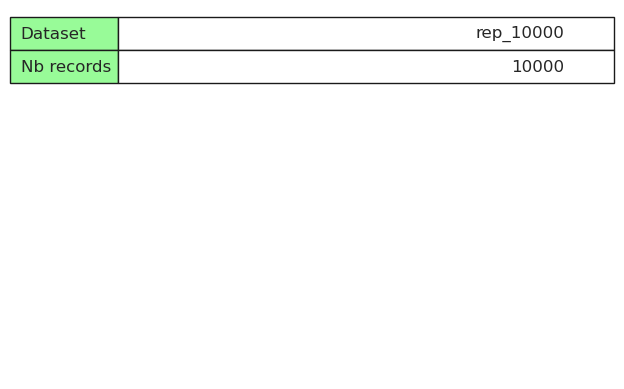

In [937]:
metadata= [["Dataset", dataset],
          ["Nb records", data.shape[0]]]


fig, ax =plt.subplots()
ax.set_axis_off() 
tbl = ax.table(cellText = [ r[1:] for r in metadata],
         rowLabels = [r[0] for r in metadata],
         rowColours = ["palegreen"] * len(metadata),
        loc="upper left")
tbl.scale(1,2)
pdf_savefig()

# Geocode

In [938]:
try: 
    no_res_timing = pd.read_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
except FileNotFoundError: 
    no_res_timing = pd.DataFrame(columns =["address", "geocoder", "duration"] )

In [939]:
import datetime
#no_res_timing ={}
def geocode_and_timeit(geocoder, addr):
    global no_res_timing
    start = datetime.datetime.now()
    res = geocoder(addr)
    if res:
        res.raw.update({"duration": datetime.datetime.now()-start})
    else: 
        geocoder_name = list(filter(lambda y: y[1] == geocoder.__self__ , [(x, geocoders[x]) for x in geocoders]))[0][0]
        
        no_res_timing = pd.concat([no_res_timing, pd.DataFrame([{"address":  addr,
                                              "duration": (datetime.datetime.now()-start).total_seconds(), 
                                              "geocoder": geocoder_name}])])
    return res

In [940]:
geocoded_data_r = [] #gpd.GeoDataFrame()
coders=["nominatim_wrapper", "nominatim", "here", "bing", "mapbox", "tomtom", "google", "bestaddress", 
        "ngi_pelias"]
coders=["nominatim_wrapper", "nominatim", "here", "bing", "google", "tomtom", "ngi_pelias"]

coders=[ "bing", "google", "here", "tomtom", "nominatim", "nominatim_wrapper", "pelias", "ngi_pelias", "jcd"]
# coders=[ "bing", "google", "here", "tomtom", "nominatim", "pelias", "photon"]

# coders=["here", "bing", "tomtom", "google", "nominatim_wrapper", "nominatim"]
# coders=["here", "bing", "tomtom", "google", "nominatim_loc"]
# coders =["nominatim_wrapper", "nominatim_loc", "pelias", "bestaddress", "pelias_plus"]

coders = ["nominatim_wrapper"]
# from_file = coders
from_file=[] 

# coders =["pelias", "pelias_struct", "ngi_pelias_basic", "ngi_pelias_simple", "ngi_pelias"]
# from_file=["pelias", "pelias_struct", ] 
# from_file = coders

coders =["ngi_pelias"]#,"nominatim_wrapper", "here", "google"]#, "here"]#, "pelias", "pelias_struct"]#, "ngi_pelias_basic", "ngi_pelias_simple"]
# from_file=[] 
from_file = coders


delay={"mapbox":0.5, "nominatim_wrapper":0.01,  "nominatim":0.01, "lpost_bestaddress": 0.01, "google":0.5, "tomtom": 0.4,
      "ngi_pelias": 0.02, "pelias": 0.02 
      }



for coder in coders: #geocoders:
    print(coder)
    
    if coder in from_file:
        print("Load from local file...")
        g_data = pd.read_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    else: 
        
        # Erase no-res timing for this coder for any previous run
        no_res_timing = no_res_timing[no_res_timing.geocoder != coder]
        
        g = geocoders[coder]
        g.geocode_timeit = lambda x: geocode_and_timeit(g.geocode, x)
        geocode = RateLimiter(g.geocode_timeit, min_delay_seconds=delay[coder] if coder in delay else 0.2)

        if coder in ["bestaddress", "ngi_pelias", 'ngi_pelias_basic', 'ngi_pelias_simple']: # structured addresses
            g_data = data.assign(location=data[["street", "housenumber", "postcode", "city"]].apply(dict, axis=1).progress_apply(geocode)).assign(geocoder=coder)
        elif coder in ["pelias_struct"]: # structured pelias
            g_data = data.assign(location=data.assign(address = data["street"]+", "+data["housenumber"]).\
                          rename(columns={"postcode": "postalcode", "city": "locality"})[["address", "postalcode", "locality"]].apply(dict, axis=1).progress_apply(geocode)).assign(geocoder=coder)

        else: 
            g_data = data.assign(location=(data['address'].str.replace("/", "%2F") if coder=="tomtom" else data['address']).progress_apply(geocode)).assign(geocoder=coder)
#             g_data = data.assign(location=data['address'].progress_apply(geocode)).assign(geocoder=coder)
        g_data.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    
    geocoded_data_r.append(g_data)
    display(g_data)
    

ngi_pelias
Load from local file...


reference_key                     street housenumber postcode  \
0                 0             de Burburelaan          46     1970   
1                 1            Nachtegalenlaan          35     1950   
2                 2              Rue Tilia(ST)          12     6511   
3                 3             Rue du Hock(N)          36     4121   
4                 4            Wuustwezelseweg          95     2990   
...             ...                        ...         ...      ...   
9995           9995        Pavé de Warquignies         108     7340   
9996           9996       Gillès de Pélichylei         150     2970   
9997           9997  Rue de l'Hospice Communal          35     1170   
9998           9998          Rue Saint-Nicolas         616     4000   
9999           9999                   Oostlaan           4     8560   

                     city                                            address  \
0         Wezembeek-Oppem  de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1                Kraainem       Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2                Beaumont         Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3                  Neupré          Rue du Hock(N), 36, 4121 Neupré, Belgique   
4              Wuustwezel     Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                   ...                                                ...   
9995          Colfontaine  Pavé de Warquignies, 108, 7340 Colfontaine, Be...   
9996              Schilde  Gillès de Pélichylei, 150, 2970 Schilde, Belgique   
9997  Watermael-Boitsfort  Rue de l'Hospice Communal, 35, 1170 Watermael-...   
9998                Liège       Rue Saint-Nicolas, 616, 4000 Liège, Belgique   
9999             Wevelgem               Oostlaan, 4, 8560 Wevelgem, Belgique   

                                               location    geocoder  
0     (46, de Burburelaan, 1970 Wezembeek-Oppem, (50...  ngi_pelias  
1     (35, Nachtegalenlaan, 1950 Kraainem, (50.85665...  ngi_pelias  
2     (12, Rue Tilia, 6511 Beaumont, (50.27311, 4.30...  ngi_pelias  
3     (36, Rue du Hock, 4121 Neupré, (50.55351, 5.45...  ngi_pelias  
4     (95, Wuustwezelseweg, 2990 Wuustwezel, (51.400...  ngi_pelias  
...                                                 ...         ...  
9995  (108, Pavé de Warquignies, 7340 Colfontaine, (...  ngi_pelias  
9996  (150, Gillès de Pélichylei, 2970 Schilde, (51....  ngi_pelias  
9997  (35, Rue de l'Hospice Communal, 1170 Watermael...  ngi_pelias  
9998  (616, Rue Saint-Nicolas, 4000 Liège, (50.64252...  ngi_pelias  
9999  (4, Oostlaan, 8560 Wevelgem, (50.85329, 3.18429))  ngi_pelias  

[10000 rows x 8 columns]

In [941]:
# with_ref = geocoded_data_r[4]
# x = geocoded_data_r[9].merge(with_ref[["address", "reference_key"]])#

# x
# data[data.street.fillna("").str.contains("Rue du Hollu(RVX)", regex=False)]

In [942]:
# x.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{x.geocoder.unique()[0]}.pkl")

## Gather results

In [943]:
geocoded_data = pd.concat(geocoded_data_r).reset_index(drop=True)
geocoded_data = geocoded_data[geocoded_data.location.notnull()]
geocoded_data

reference_key                     street housenumber postcode  \
0                 0             de Burburelaan          46     1970   
1                 1            Nachtegalenlaan          35     1950   
2                 2              Rue Tilia(ST)          12     6511   
3                 3             Rue du Hock(N)          36     4121   
4                 4            Wuustwezelseweg          95     2990   
...             ...                        ...         ...      ...   
9995           9995        Pavé de Warquignies         108     7340   
9996           9996       Gillès de Pélichylei         150     2970   
9997           9997  Rue de l'Hospice Communal          35     1170   
9998           9998          Rue Saint-Nicolas         616     4000   
9999           9999                   Oostlaan           4     8560   

                     city                                            address  \
0         Wezembeek-Oppem  de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1                Kraainem       Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2                Beaumont         Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3                  Neupré          Rue du Hock(N), 36, 4121 Neupré, Belgique   
4              Wuustwezel     Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                   ...                                                ...   
9995          Colfontaine  Pavé de Warquignies, 108, 7340 Colfontaine, Be...   
9996              Schilde  Gillès de Pélichylei, 150, 2970 Schilde, Belgique   
9997  Watermael-Boitsfort  Rue de l'Hospice Communal, 35, 1170 Watermael-...   
9998                Liège       Rue Saint-Nicolas, 616, 4000 Liège, Belgique   
9999             Wevelgem               Oostlaan, 4, 8560 Wevelgem, Belgique   

                                               location    geocoder  
0     (46, de Burburelaan, 1970 Wezembeek-Oppem, (50...  ngi_pelias  
1     (35, Nachtegalenlaan, 1950 Kraainem, (50.85665...  ngi_pelias  
2     (12, Rue Tilia, 6511 Beaumont, (50.27311, 4.30...  ngi_pelias  
3     (36, Rue du Hock, 4121 Neupré, (50.55351, 5.45...  ngi_pelias  
4     (95, Wuustwezelseweg, 2990 Wuustwezel, (51.400...  ngi_pelias  
...                                                 ...         ...  
9995  (108, Pavé de Warquignies, 7340 Colfontaine, (...  ngi_pelias  
9996  (150, Gillès de Pélichylei, 2970 Schilde, (51....  ngi_pelias  
9997  (35, Rue de l'Hospice Communal, 1170 Watermael...  ngi_pelias  
9998  (616, Rue Saint-Nicolas, 4000 Liège, (50.64252...  ngi_pelias  
9999  (4, Oostlaan, 8560 Wevelgem, (50.85329, 3.18429))  ngi_pelias  

[9999 rows x 8 columns]

In [944]:
# geocoded_data["geocoder"]=geocoded_data["geocoder"].replace("ngi_pelias", "pelias_plus")
# coders.append("pelias_plus")
# coders.remove("ngi_pelias")
# x = data.merge(geocoded_data[geocoded_data.geocoder=="ngi_pelias"].drop("address", axis=1)[["reference_key", "street", "housenumber", "postcode", "city"]].rename(columns={"street" : "pelias_street", 
#                                                                        "housenumber": "pelias_housenumber" ,
#                                                                        "postcode": "pelias_postcodee",
#                                                                        "city": "pelias_city"}), how="left")
# x

In [945]:
geocoded_data.geocoder.value_counts()

ngi_pelias    9999
Name: geocoder, dtype: int64

# Duration

In [946]:
geocoded_data["duration"] = geocoded_data["location"].apply(lambda loc: loc.raw["duration"] if loc and "duration" in loc.raw else None).dt.total_seconds()

In [947]:
geocoded_data.groupby("geocoder").address.count().sum()#["duration"]


9999

In [948]:
no_res_timing.to_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")

In [949]:
geocoded_data_duration = pd.concat([geocoded_data.assign(with_result=True), 
                                    no_res_timing[no_res_timing.geocoder.isin(coders)].assign(with_result=False)])
geocoded_data_duration = geocoded_data_duration.reset_index()[["address", "geocoder", "duration", "with_result"]]
geocoded_data_duration["address"] = geocoded_data_duration["address"].astype(str)

In [950]:
geocoded_data_duration.sort_values("duration")

address    geocoder  duration  \
5911           Place Communale, 1, 5537 Anhée, Belgique  ngi_pelias  0.011567   
5959            Vaatjesstraat, 14, 2580 Putte, Belgique  ngi_pelias  0.011677   
5958            Houwendijk, 15, 2370 Arendonk, Belgique  ngi_pelias  0.011751   
6096         Morgenster, 25, 9250 Waasmunster, Belgique  ngi_pelias  0.011927   
8465               Tenhole, 8, 9681 Maarkedal, Belgique  ngi_pelias  0.012039   
...                                                 ...         ...       ...   
7301  Rue Claie - AIX-s-CLOIE, 3, 6792 Aubange, Belg...  ngi_pelias  2.944019   
6954   Rue del'vaux, Gd-L., 38, 5031 Gembloux, Belgique  ngi_pelias  3.023592   
2733  Rue d'Inzepia,M.-St-Blaise, 22, 5560 Houyet, B...  ngi_pelias  3.199744   
7100  Rue Notre Dame, Ermeton-s.-B., 23, 5644 Mettet...  ngi_pelias  3.375874   
1518  Rue de Beauvechain,T.-la-G., 16, 1320 Beauvech...  ngi_pelias  3.982274   

      with_result  
5911         True  
5959         True  
5958         True  
6096         True  
8465         True  
...           ...  
7301         True  
6954         True  
2733         True  
7100         True  
1518         True  

[10000 rows x 4 columns]

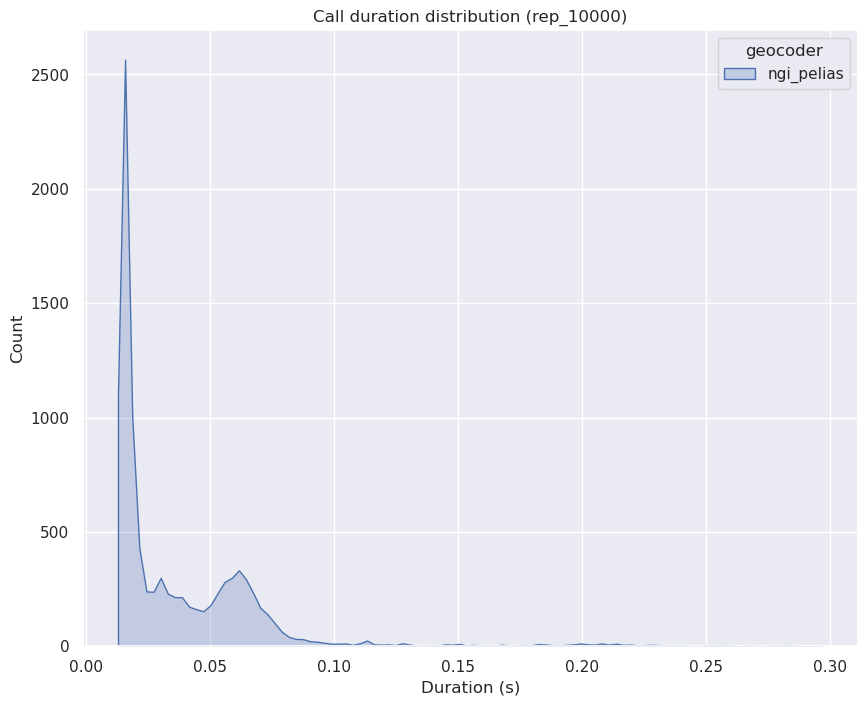

In [951]:
plt.figure(figsize=def_figsize)
sbn.histplot(geocoded_data_duration[geocoded_data_duration.duration<0.3].sort_values("geocoder"), 
             x="duration", hue="geocoder", element="poly",
            bins=100).set(title=f'Call duration distribution ({dataset})', xlabel="Duration (s)")

pdf_savefig()
    

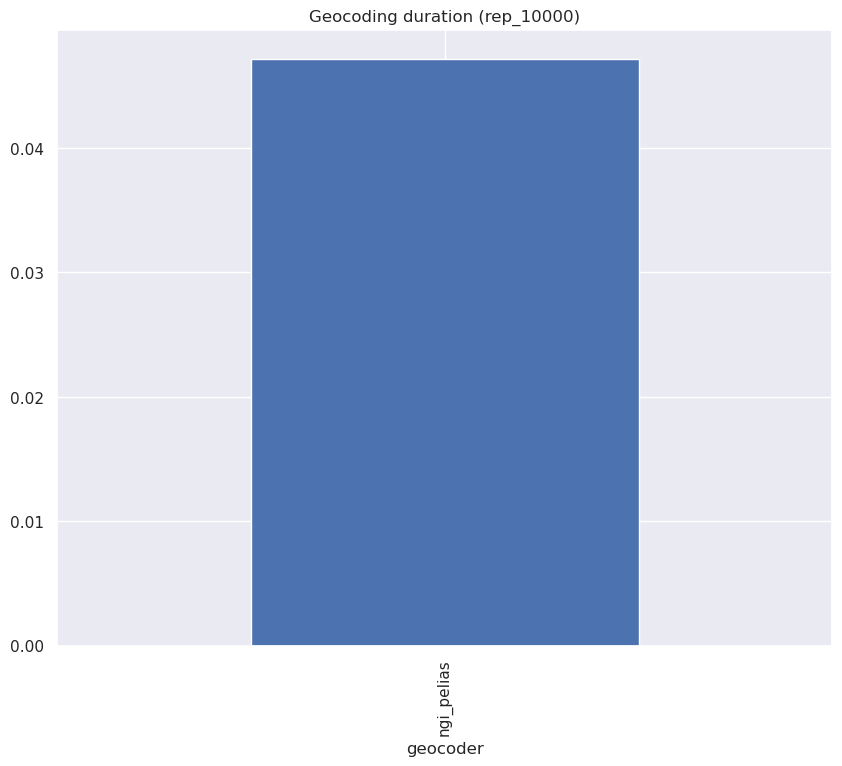

In [952]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

geocoded_data_duration.groupby("geocoder").duration.mean().plot.bar(color=colors, 
                                                                    title=f"Geocoding duration ({dataset})",
                                                                   figsize=def_figsize)
plt.savefig(f'{fig_path}/geocoding_speed.png', dpi=150,  bbox_inches='tight')

pdf_savefig()

<Axes: title={'center': 'Geocoding duration (rep_10000)'}, xlabel='geocoder'>

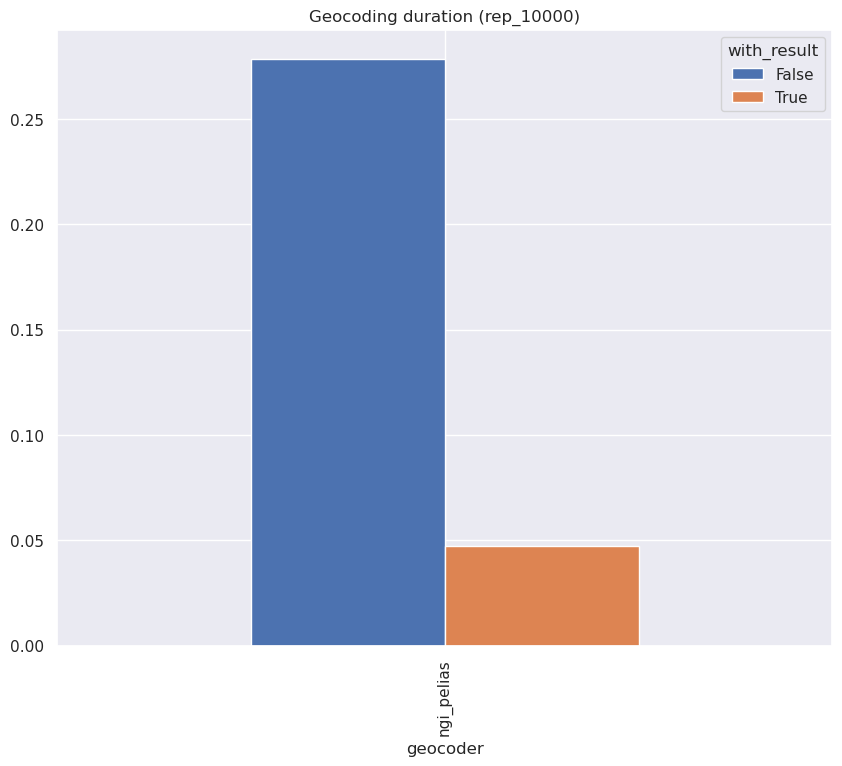

In [953]:
geocoded_data_duration.groupby(["geocoder", "with_result"]).duration.mean().unstack().plot.bar(title=f"Geocoding duration ({dataset})",
                                                                                              figsize=def_figsize)

In [954]:
# geocoded_data_duration[geocoded_data_duration.geocoder=="tomtom"]

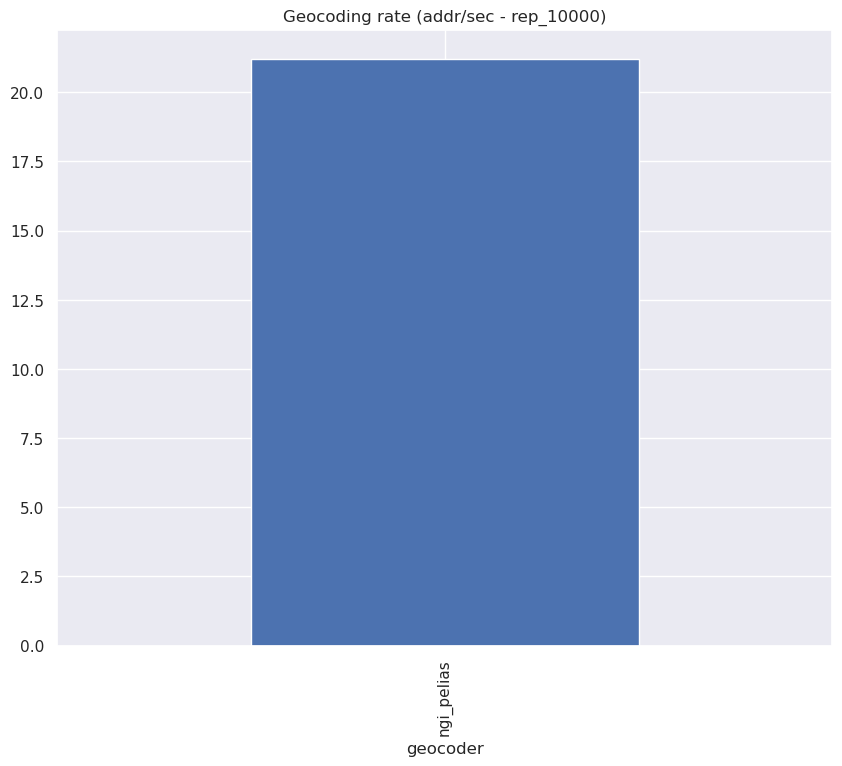

In [955]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

(1/geocoded_data_duration.groupby("geocoder").duration.mean()).plot.bar(color=colors, 
                                                                        title=f"Geocoding rate (addr/sec - {dataset})",
                                                                        figsize=def_figsize)
# plt.savefig(f'{fig_path}/geocoding_speed_rate.png', dpi=150,  bbox_inches='tight')

pdf_savefig()

# Matching rate

## Matching rate

In [956]:
# geocoded_data[geocoded_data.geocoder=="jcd"].reference_key.isnull().value_counts()

In [957]:
data

reference_key                     street housenumber postcode  \
0                 0             de Burburelaan          46     1970   
1                 1            Nachtegalenlaan          35     1950   
2                 2              Rue Tilia(ST)          12     6511   
3                 3             Rue du Hock(N)          36     4121   
4                 4            Wuustwezelseweg          95     2990   
...             ...                        ...         ...      ...   
9995           9995        Pavé de Warquignies         108     7340   
9996           9996       Gillès de Pélichylei         150     2970   
9997           9997  Rue de l'Hospice Communal          35     1170   
9998           9998          Rue Saint-Nicolas         616     4000   
9999           9999                   Oostlaan           4     8560   

                     city                                            address  
0         Wezembeek-Oppem  de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...  
1                Kraainem       Nachtegalenlaan, 35, 1950 Kraainem, Belgique  
2                Beaumont         Rue Tilia(ST), 12, 6511 Beaumont, Belgique  
3                  Neupré          Rue du Hock(N), 36, 4121 Neupré, Belgique  
4              Wuustwezel     Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique  
...                   ...                                                ...  
9995          Colfontaine  Pavé de Warquignies, 108, 7340 Colfontaine, Be...  
9996              Schilde  Gillès de Pélichylei, 150, 2970 Schilde, Belgique  
9997  Watermael-Boitsfort  Rue de l'Hospice Communal, 35, 1170 Watermael-...  
9998                Liège       Rue Saint-Nicolas, 616, 4000 Liège, Belgique  
9999             Wevelgem               Oostlaan, 4, 8560 Wevelgem, Belgique  

[10000 rows x 6 columns]

In [958]:
mr = (geocoded_data.groupby("geocoder").address.count()/ data.shape[0])

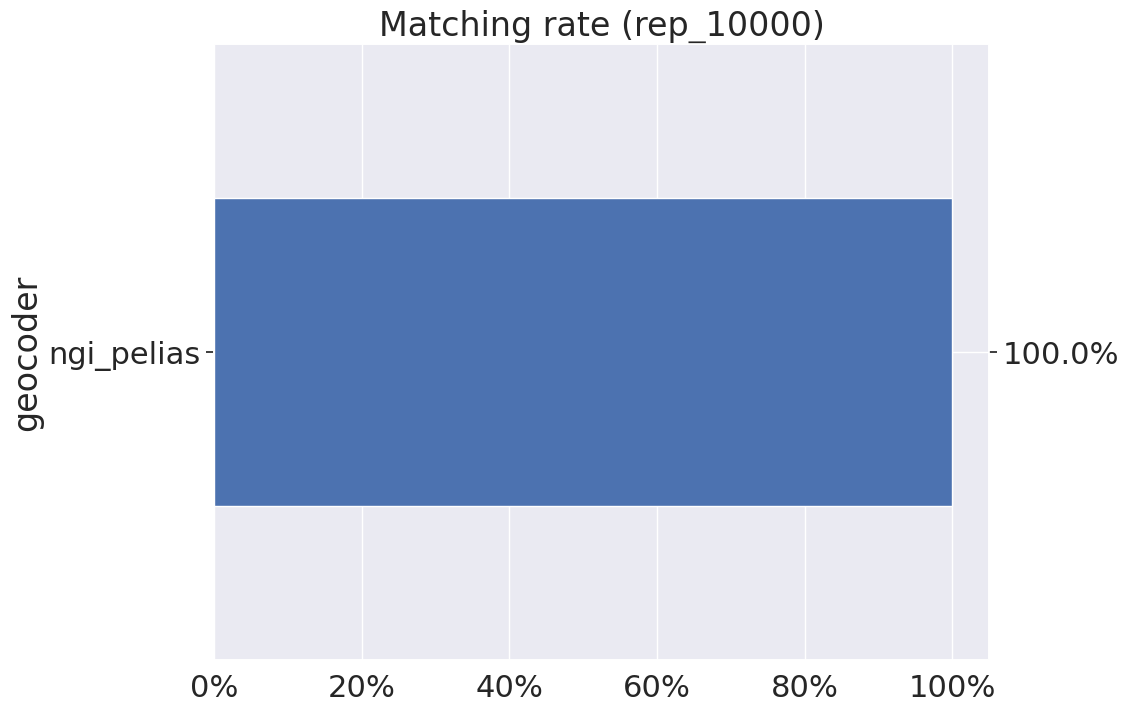

In [959]:
def show_values_on_hbars(ax, values):
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels(values.apply("{:.1%}".format))#mr_prec_plot.get_yticklabels())
    # ax2.xaxis.set_major_formatter('')
    ax2.grid(axis='y')   
    
    


plt.figure(figsize=def_figsize)
sbn.set(font_scale=2)

mr_plot=mr.rename("matching rate").plot.barh(title=f"Matching rate ({dataset})")

show_values_on_hbars(mr_plot, mr)


mr_plot.xaxis.set_major_formatter('{x:.0%}')


pdf_savefig()

sbn.set(font_scale=1)



In [960]:
# geocoded_data.groupby("address").geocoder.count().value_counts().sort_index(ascending=False).plot.bar(title="Number of success per address")

## Extract precision

In [961]:
geocoded_data["precision"] = geocoded_data.apply(get_precision, axis=1)

In [962]:
geocoded_data[geocoded_data.precision.str.contains("UNK")][["geocoder" , "precision"]].value_counts()#drop_duplicates()

Series([], dtype: int64)

In [963]:
geocoded_data[geocoded_data.precision.str.contains("UNK")]

Empty DataFrame
Columns: [reference_key, street, housenumber, postcode, city, address, location, geocoder, duration, precision]
Index: []

In [964]:
geocoded_data["precision"] = geocoded_data.precision.replace("^\[UNKNOWN.*\]", "[UNKNOWN]", regex=True)

## Precision

In [965]:
mr

geocoder
ngi_pelias    0.9999
Name: address, dtype: float64

In [966]:
def plot_matching_rate(geocoded_data, title=f"Matching rate - Precision ({dataset})"):
    sbn.set(font_scale=2)
    mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
    mr_prec = mr_prec/data.shape[0]
    mr_prec = mr_prec.reindex(["building", "street", "city", "country"], axis=1).reindex(coders, axis=0) # , "[UNKNOWN]"

    mr_prec_plot= mr_prec.plot.barh(stacked=True, 
                                    figsize=def_figsize, 
                                    title=title, 
                                    color=["tab:green", "tab:orange", "tab:red", "darkred" , "tab:grey"])
    mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')

    mr_prec_plot.set_ylabel(None)

    plt.legend(loc='lower left')

    show_values_on_hbars(mr_prec_plot, mr.reindex(coders))

    for bars in mr_prec_plot.containers:
        mr_prec_plot.bar_label(bars, label_type="center", fmt=lambda x: "{0:.0%}".format(x) if x >0.005 else "", fontproperties={"size":"x-small"})


    plt.savefig(f'{fig_path}/matching_rate_{dataset}.png', dpi=150,  bbox_inches='tight')

    sbn.set(font_scale=1)
    
    return mr_prec


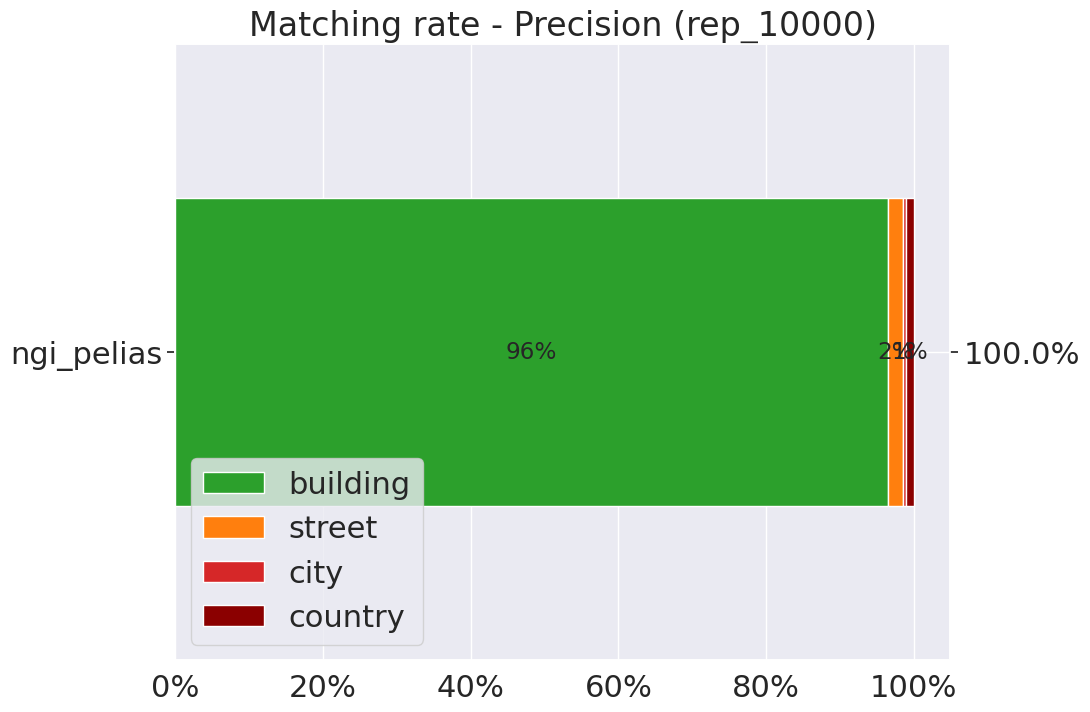

In [967]:
mr_prec = plot_matching_rate(geocoded_data)
pdf_savefig()

In [968]:
# no builing MR (for Nominatim):
# best : 31.6+0.4 = 32 %
# kbo : 24+1 = 25 %
# resto : 13.1 + 4.5 = 17.5 
with pd.option_context('display.float_format', '{:0.1%}'.format):
    display(mr_prec.fillna(""))


precision   building  street  city  country
geocoder                                   
ngi_pelias     96.5%    2.1%  0.4%     1.0%

In [969]:
# kbo: ngi_pelias	93.4%	5.6%	0.9%	0.1%
#                   94.6%	4.5%	0.8%	0.1%
# rep: 94.4%	5.1%	0.4%	0.1%
#      95.8%	3.1%	0.4%	0.7%

# rrn: 97.3%	1.3%	0.3%	1.1%

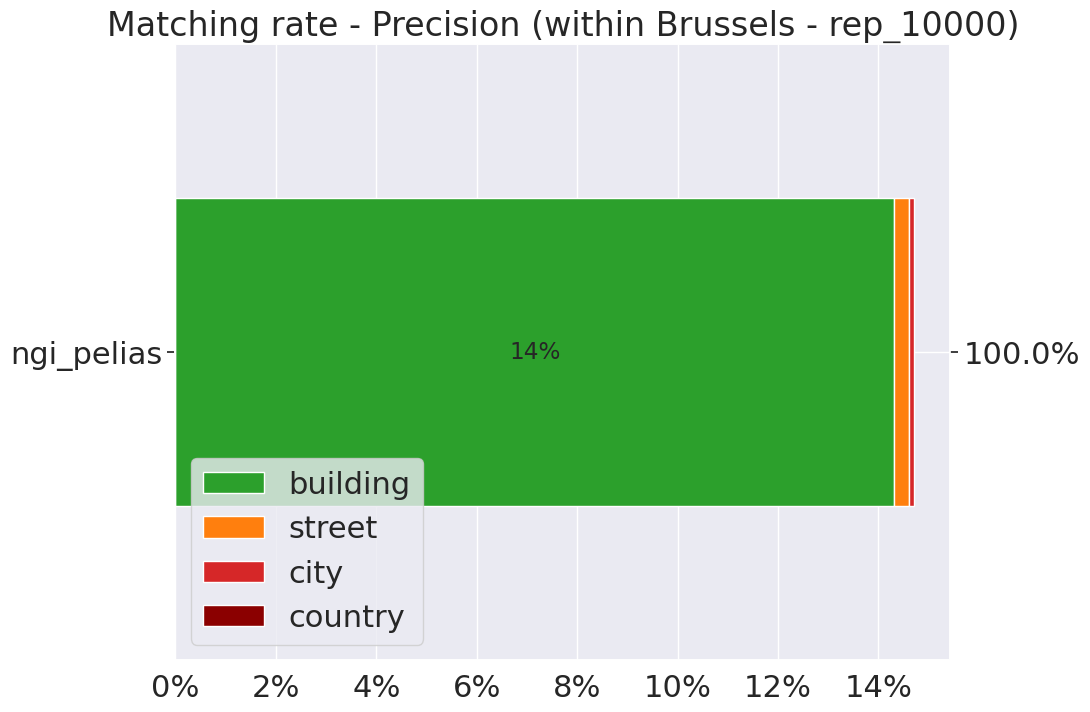

In [970]:
# geocoded_data
addr_in_bru = geocoded_data[geocoded_data.postcode.astype(int).between(1000, 1299)].address
geocoded_data_bru = geocoded_data[geocoded_data.address.isin(addr_in_bru)] 

mr_prec = plot_matching_rate(geocoded_data_bru, f"Matching rate - Precision (within Brussels - {dataset})")
pdf_savefig()

# Distance to median statistics

## Extract location

In [710]:
lat = geocoded_data["location"].apply(lambda loc: loc.point.latitude if loc and loc.point.latitude >0 else None)
lng =  geocoded_data["location"].apply(lambda loc: loc.point.longitude if loc else None)
geocoded_data["point"] = np.where(lat.notnull(), gpd.points_from_xy(lng, lat), pd.NA)

In [711]:
geocoded_data[geocoded_data.point.isnull()]

reference_key                          street housenumber postcode  \
51               51                  Route d' Aubel          69     4890   
352             352                Rue Delannay(FR)          10     7504   
546             546                Rue des Ecomines          39     4900   
597             597              Rue Troisfontaines          92     4670   
668             668  Rue Fosses-aux-Chênes,Aisemont        144B     5070   
...             ...                             ...         ...      ...   
9044           9044                Rue Sergent Ratz           2     6690   
9291           9291                 Chaussée de Huy         205     1325   
9689           9689           Rue Joncquerelle(G-R)          80     7530   
9748           9748                     Grands Trys          20     4861   
9955           9955    Rue de la Chaudronnerie(PAC)           4     6230   

                    city                                            address  \
51    Thimister-Clermont  Route d' Aubel, 69, 4890 Thimister-Clermont, B...   
352              Tournai       Rue Delannay(FR), 10, 7504 Tournai, Belgique   
546                  Spa           Rue des Ecomines, 39, 4900 Spa, Belgique   
597               Blégny      Rue Troisfontaines, 92, 4670 Blégny, Belgique   
668      Fosses-la-Ville  Rue Fosses-aux-Chênes,Aisemont, 144B, 5070 Fos...   
...                  ...                                                ...   
9044            Vielsalm       Rue Sergent Ratz, 2, 6690 Vielsalm, Belgique   
9291    Chaumont-Gistoux  Chaussée de Huy, 205, 1325 Chaumont-Gistoux, B...   
9689             Tournai  Rue Joncquerelle(G-R), 80, 7530 Tournai, Belgique   
9748           Pepinster          Grands Trys, 20, 4861 Pepinster, Belgique   
9955       Pont-à-Celles  Rue de la Chaudronnerie(PAC), 4, 6230 Pont-à-C...   

                                               location    geocoder  duration  \
51    (69, Route d'Aubel, 4890 Thimister-Clermont, (...  ngi_pelias  0.086635   
352     (10bis, Rue Delannay, 7504 Tournai, (0.0, 0.0))  ngi_pelias  0.088429   
546        (39, Rue des Ecomines, 4900 Spa, (0.0, 0.0))  ngi_pelias  0.080474   
597   (92, Rue Troisfontaines, 4670 Blegny, (0.0, 0.0))  ngi_pelias  0.081688   
668   (Rue Fosses-aux-Chênes, 5070 Fosses-la-Ville, ...  ngi_pelias  0.292199   
...                                                 ...         ...       ...   
9044      (Rue Sergent Ratz, 6690 Vielsalm, (0.0, 0.0))  ngi_pelias  0.167836   
9291  (205, Chaussée de Huy, 1325 Chaumont-Gistoux, ...  ngi_pelias  0.072710   
9689   (80, Rue Joncquerelle, 7530 Tournai, (0.0, 0.0))  ngi_pelias  0.080754   
9748          (Grands Trys, 4861 Pepinster, (0.0, 0.0))  ngi_pelias  0.175256   
9955  (4, Rue de la Chaudronnerie, 6230 Pont-à-Celle...  ngi_pelias  0.093202   

     precision point  
51     country  <NA>  
352    country  <NA>  
546    country  <NA>  
597    country  <NA>  
668    country  <NA>  
...        ...   ...  
9044   country  <NA>  
9291   country  <NA>  
9689   country  <NA>  
9748   country  <NA>  
9955   country  <NA>  

[64 rows x 11 columns]

<Axes: >

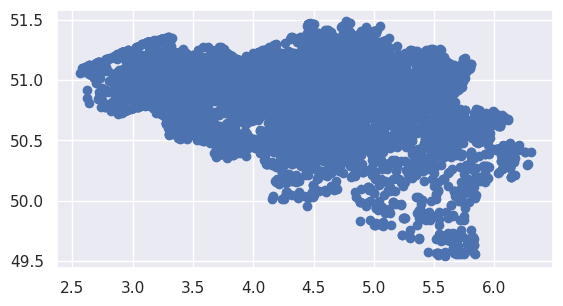

In [712]:
geocoded_data[geocoded_data.point.notnull()].set_geometry("point").plot()

In [713]:
geocoded_data = geocoded_data[geocoded_data.point.notnull()] 

In [714]:
geocoded_data = gpd.GeoDataFrame(geocoded_data).set_geometry("point").set_crs(osm_crs, allow_override=True).to_crs(crs)
geocoded_data

reference_key                street housenumber postcode  \
0                 0  Dendermondsesteenweg         200     2830   
1                 1   Boulevard du Régent          47     1000   
2                 2              Hauwaart          44     9700   
3                 3       Bruynebosstraat          40     3511   
4                 4     Steenwinkelstraat         583     2627   
...             ...                   ...         ...      ...   
9995           9995        Willy Staeslei          51     2180   
9996           9996      Oesterbankstraat          15     8400   
9997           9997                 Peene          10     9185   
9998           9998         Breekpot(Onk)          28     9500   
9999           9999         Jagerslaan(M)           8     3630   

                city                                            address  \
0         Willebroek  Dendermondsesteenweg, 200, 2830 Willebroek, Be...   
1          Bruxelles  Boulevard du Régent, 47, 1000 Bruxelles, Belgique   
2         Oudenaarde            Hauwaart, 44, 9700 Oudenaarde, Belgique   
3            Hasselt        Bruynebosstraat, 40, 3511 Hasselt, Belgique   
4            Schelle     Steenwinkelstraat, 583, 2627 Schelle, Belgique   
...              ...                                                ...   
9995       Antwerpen       Willy Staeslei, 51, 2180 Antwerpen, Belgique   
9996        Oostende      Oesterbankstraat, 15, 8400 Oostende, Belgique   
9997      Wachtebeke               Peene, 10, 9185 Wachtebeke, Belgique   
9998  Geraardsbergen   Breekpot(Onk), 28, 9500 Geraardsbergen, Belgique   
9999    Maasmechelen      Jagerslaan(M), 8, 3630 Maasmechelen, Belgique   

                                               location    geocoder  duration  \
0     (200, Dendermondsesteenweg, 2830 Willebroek, (...  ngi_pelias  0.094519   
1     (47, Boulevard du Régent, 1000 Bruxelles, (50....  ngi_pelias  0.058291   
2     (44, Hauwaart, 9700 Oudenaarde, (50.83173, 3.6...  ngi_pelias  0.023721   
3     (40, Bruynebosstraat, 3511 Hasselt, (50.97784,...  ngi_pelias  0.026742   
4     (583, Steenwinkelstraat, 2627 Schelle, (51.122...  ngi_pelias  0.090173   
...                                                 ...         ...       ...   
9995  (51, Willy Staeslei, 2180 Antwerpen, (51.28986...  ngi_pelias  0.017115   
9996  (15, Oesterbankstraat, 8400 Oostende, (51.2263...  ngi_pelias  0.014782   
9997  (10, Peene, 9185 Wachtebeke, (51.17133, 3.88639))  ngi_pelias  0.013771   
9998  (28, Breekpot, 9500 Geraardsbergen, (50.78497,...  ngi_pelias  0.038913   
9999  (8, Jagerslaan, 3630 Maasmechelen, (50.95825, ...  ngi_pelias  0.036637   

     precision                           point  
0     building  POINT (483875.770 6631823.569)  
1     building  POINT (486332.591 6594343.048)  
2     building  POINT (407795.577 6591582.510)  
3     building  POINT (586172.816 6617374.811)  
4     building  POINT (486022.010 6643028.472)  
...        ...                             ...  
9995  building  POINT (494324.218 6672727.651)  
9996  building  POINT (325556.077 6661430.506)  
9997  building  POINT (432630.956 6651656.155)  
9998  building  POINT (435366.076 6583345.186)  
9999  building  POINT (631582.263 6613911.951)  

[9936 rows x 11 columns]

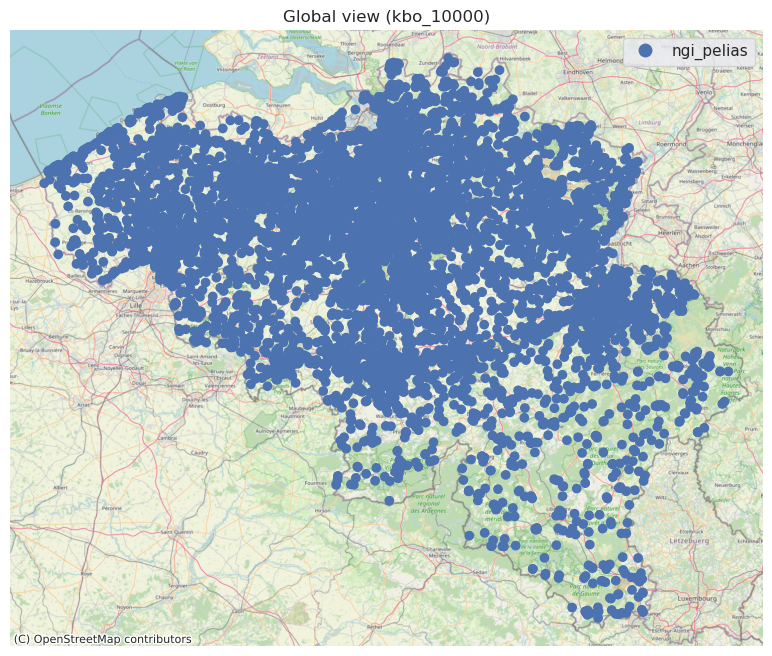

In [715]:
from matplotlib.colors import ListedColormap

colors = ListedColormap([f"C{i}" for i in range(geocoded_data.geocoder.nunique())], name="mycmap")
ax=geocoded_data.plot("geocoder", legend=True, figsize=def_figsize, cmap=colors)
plt.title(f"Global view ({dataset})")
add_basemap(ax)
# img_name=f"{fig_path}/global_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name)
# pdf.add_page()
# pdf.image(f"{fig_path}/global_{dataset}.png", 0, 0, 290)
plt.axis("off")
pdf_savefig()
# plt.show()
# plt.close()

In [716]:
belgium_boundaries = gpd.read_file("data/boundaries.geojson", driver="GeoJSON")
belgium_boundaries = belgium_boundaries[belgium_boundaries.name == "BEL"].geometry.iloc[0].simplify(1000).buffer(1000)
# belgium_boundaries

In [717]:
geocoded_data["is_in_belgium"]= geocoded_data.geometry.within(belgium_boundaries)
geocoded_data["is_in_belgium"].value_counts()

True     9935
False       1
Name: is_in_belgium, dtype: int64

In [718]:
geocoded_data[~geocoded_data.is_in_belgium]

reference_key       street housenumber postcode           city  \
4269           4269  Molenstraat          66     2387  Baarle-Hertog   

                                            address  \
4269  Molenstraat, 66, 2387 Baarle-Hertog, Belgique   

                                               location    geocoder  duration  \
4269  (66, Molenstraat, 2387 Baarle-Hertog, (51.4390...  ngi_pelias  0.019231   

     precision                           point  is_in_belgium  
4269  building  POINT (549092.294 6699321.787)          False

In [719]:
geocoded_data.groupby("geocoder").is_in_belgium.value_counts()

geocoder    is_in_belgium
ngi_pelias  True             9935
            False               1
Name: is_in_belgium, dtype: int64

In [720]:
geocoded_data[~geocoded_data.is_in_belgium]

reference_key       street housenumber postcode           city  \
4269           4269  Molenstraat          66     2387  Baarle-Hertog   

                                            address  \
4269  Molenstraat, 66, 2387 Baarle-Hertog, Belgique   

                                               location    geocoder  duration  \
4269  (66, Molenstraat, 2387 Baarle-Hertog, (51.4390...  ngi_pelias  0.019231   

     precision                           point  is_in_belgium  
4269  building  POINT (549092.294 6699321.787)          False

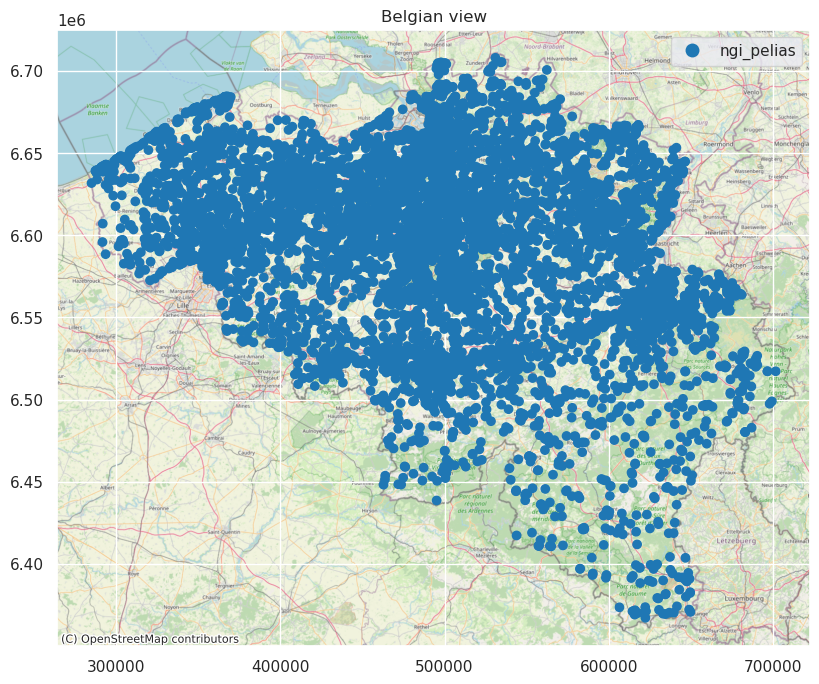

In [721]:
ax=geocoded_data[geocoded_data.is_in_belgium].plot("geocoder", legend=True, figsize=def_figsize)
plt.title("Belgian view")
add_basemap(ax)
pdf_savefig()

## Compute (distance to) median

In [722]:
def get_median_point(bloc):
    bloc = gpd.GeoSeries(bloc.dropna())
    x = np.median(bloc.x)
    y = np.median(bloc.y)
    return shapely.geometry.Point(x, y), bloc.shape[0]
 

In [723]:
# geocoded_data.address.drop_duplicates()

In [724]:
median_geocoders = coders # ["here", "bing", "mapbox", "tomtom", "nominatim_wrapper", "google", "bestaddress"] # Median based on those geocoders
median_points = geocoded_data[geocoded_data.geocoder.isin(median_geocoders)&( geocoded_data.precision=="building") ].groupby("address").point.apply(get_median_point).apply(pd.Series)#.rename("median_point").reset_index()
median_points = median_points.rename(columns={0: "median_point", 1: "nb_points"}).reset_index()
median_points = median_points.set_geometry("median_point").set_crs(geocoded_data.crs)
median_points

address  \
0           "Le Rosai", 5, 4052 Chaudfontaine, Belgique   
1        's Boschstraat, 30, 2320 Hoogstraten, Belgique   
2     's Gravenwezelsteenweg, 59, 2110 Wijnegem, Bel...   
3             's Heerwillems, 14, 8630 Veurne, Belgique   
4                's Herenbaan, 211, 2850 Boom, Belgique   
...                                                 ...   
9468  rue du Barrage,Robertville, 46, 4950 Waimes, B...   
9469      rue du Chapy,Ws, 52, 5570 Beauraing, Belgique   
9470    rue du Luxembourg, 70, 5570 Beauraing, Belgique   
9471      van Willigenstraat, 32, 3560 Lummen, Belgique   
9472  à la Corne du Pré, 9, 4053 Chaudfontaine, Belg...   

                        median_point  nb_points  
0     POINT (626914.637 6542984.218)          1  
1     POINT (530633.296 6693148.708)          1  
2     POINT (504788.072 6662903.479)          1  
3     POINT (305100.008 6634854.577)          1  
4     POINT (486443.911 6639971.392)          1  
...                              ...        ...  
9468  POINT (680587.329 6525451.654)          1  
9469  POINT (552306.088 6462239.508)          1  
9470  POINT (553236.719 6464743.706)          1  
9471  POINT (576978.940 6618179.309)          1  
9472  POINT (625804.781 6549257.506)          1  

[9473 rows x 3 columns]

<Axes: ylabel='nb_points'>

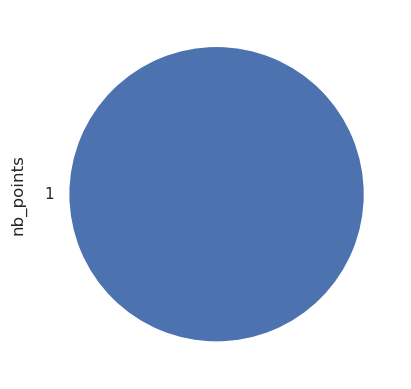

In [725]:
median_points.nb_points.value_counts().plot.pie()

In [726]:
median_points = median_points[median_points.nb_points >= min(3,median_points.nb_points.max()) ]
median_points.shape

(9473, 3)

In [727]:
geocoded_data = geocoded_data.merge(median_points, how="left")#.dropna()
# geocoded_data

In [728]:
geocoded_data["dist_to_median"] = geocoded_data.point.distance(geocoded_data.median_point.set_crs(geocoded_data.crs))
geocoded_data.sort_values("dist_to_median")#.tail(100)

reference_key                     street housenumber postcode  \
0                 0       Dendermondsesteenweg         200     2830   
6616           6663          Rue de Givry(VSC)          28     7120   
6618           6665    Jan Frans Willemsstraat           3     2530   
6619           6666            Koekoekenstraat           9     3078   
6620           6667          Nachtegalenstraat          32     3001   
...             ...                        ...         ...      ...   
9863           9926    Rue Neuve Chaussée(PER)          SN     7600   
9891           9954                Zonnestraat           -     3560   
9892           9956               Mechelsebaan          ZN     2570   
9909           9973  Rue Léon-Colleaux,St-Mard          SN     6762   
9930           9994    Weyler, Zone artisanale           1     6700   

            city                                            address  \
0     Willebroek  Dendermondsesteenweg, 200, 2830 Willebroek, Be...   
6616    Estinnes     Rue de Givry(VSC), 28, 7120 Estinnes, Belgique   
6618    Boechout  Jan Frans Willemsstraat, 3, 2530 Boechout, Bel...   
6619  Kortenberg      Koekoekenstraat, 9, 3078 Kortenberg, Belgique   
6620      Leuven       Nachtegalenstraat, 32, 3001 Leuven, Belgique   
...          ...                                                ...   
9863    Péruwelz  Rue Neuve Chaussée(PER), SN, 7600 Péruwelz, Be...   
9891      Lummen              Zonnestraat, -, 3560 Lummen, Belgique   
9892      Duffel            Mechelsebaan, ZN, 2570 Duffel, Belgique   
9909      Virton  Rue Léon-Colleaux,St-Mard, SN, 6762 Virton, Be...   
9930       Arlon   Weyler, Zone artisanale, 1, 6700 Arlon, Belgique   

                                               location    geocoder  duration  \
0     (200, Dendermondsesteenweg, 2830 Willebroek, (...  ngi_pelias  0.094519   
6616  (28, Rue de Givry, 7120 Estinnes, (50.39891, 4...  ngi_pelias  0.058121   
6618  (3, Jan Frans Willemsstraat, 2530 Boechout, (5...  ngi_pelias  0.080690   
6619  (9, Koekoekenstraat, 3078 Kortenberg, (50.8731...  ngi_pelias  0.014218   
6620  (32, Nachtegalenstraat, 3001 Leuven, (50.86083...  ngi_pelias  0.016698   
...                                                 ...         ...       ...   
9863  (Rue Neuve Chaussée, 7600 Péruwelz, (50.517451...  ngi_pelias  2.598087   
9891  (Zonnestraat, 3560 Lummen, (50.988926, 5.195656))  ngi_pelias  0.351131   
9892  (Mechelsebaan, 2570 Duffel, (51.083837, 4.5023...  ngi_pelias  0.238932   
9909  (Rue Léon Colleaux, 6762 Virton, (49.555232, 5...  ngi_pelias  0.420416   
9930  (Chemin de Weyler, 6700 Arlon, (49.670202, 5.8...  ngi_pelias  0.210257   

     precision                           point  is_in_belgium  \
0     building  POINT (483875.770 6631823.569)           True   
6616  building  POINT (451298.121 6515648.793)           True   
6618  building  POINT (500250.867 6650101.010)           True   
6619  building  POINT (504910.701 6598882.497)           True   
6620  building  POINT (522559.293 6596712.984)           True   
...        ...                             ...            ...   
9863    street  POINT (400758.961 6536376.216)           True   
9891    street  POINT (578377.780 6619335.094)           True   
9892    street  POINT (501197.751 6636136.937)           True   
9909    street  POINT (615769.663 6369603.202)           True   
9930    street  POINT (647449.966 6389355.333)           True   

                        median_point  nb_points  dist_to_median  
0     POINT (483875.770 6631823.569)        1.0             0.0  
6616  POINT (451298.121 6515648.793)        1.0             0.0  
6618  POINT (500250.867 6650101.010)        1.0             0.0  
6619  POINT (504910.701 6598882.497)        1.0             0.0  
6620  POINT (522559.293 6596712.984)        1.0             0.0  
...                              ...        ...             ...  
9863                            None        NaN             NaN  
9891              

In [729]:
# geocoded_data[geocoded_data.median_point.isnull()].sort_values("address")

In [730]:
# geocoded_data.sort_values("dist_to_median").tail(40).geocoder.value_counts().plot.bar()

In [731]:
def plot_address(geocoded_data, a):
    df = geocoded_data[(geocoded_data.address==a)]
    display(df)
    

    ax = df.assign(label=df.geocoder + " ("+df.dist_to_median.fillna(-1).astype(int).astype(str) + " - " + df.precision + ")").plot(
        "label", 
        legend=True, 
        markersize=100,
            figsize=def_figsize
    )

    if df.dist_to_median.isnull().all():
        print("No median point")
    else: 
        med=df[["median_point"]].drop_duplicates().set_geometry("median_point")
                                                                                                                         
        med.plot(ax=ax, color="red", marker="x", markersize=100)
    ax.set_title(a)
    set_optimal_limits(ax, df)
    add_basemap(ax)
    plt.show()    
    return ax

In [732]:
# plot_address(geocoded_data, geocoded_data.loc[46].address)

reference_key                street housenumber postcode        city  \
0              0  Dendermondsesteenweg         200     2830  Willebroek   

                                             address  \
0  Dendermondsesteenweg, 200, 2830 Willebroek, Be...   

                                            location    geocoder  duration  \
0  (200, Dendermondsesteenweg, 2830 Willebroek, (...  ngi_pelias  0.094519   

  precision                           point  is_in_belgium  \
0  building  POINT (483875.770 6631823.569)           True   

                     median_point  nb_points  dist_to_median  
0  POINT (483875.770 6631823.569)        1.0             0.0

/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


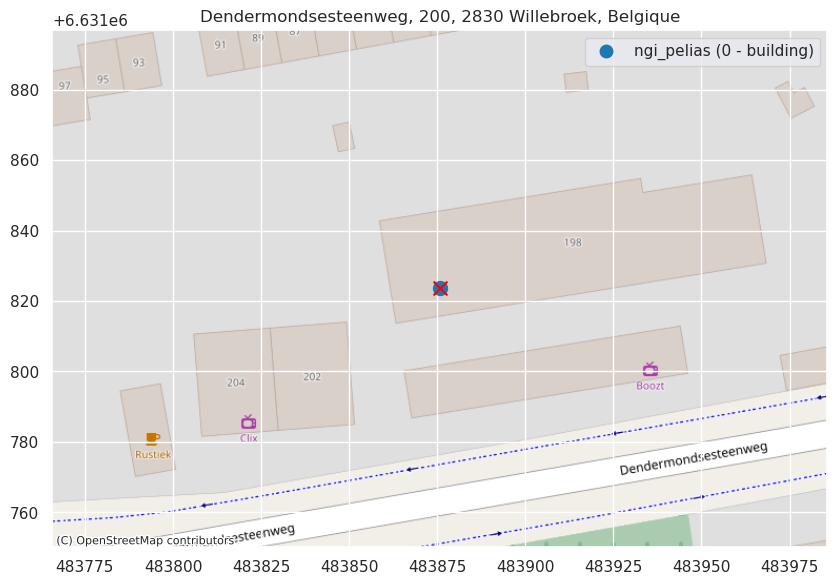

reference_key          street housenumber postcode     city  \
6615           6662  Nieuwkamp(Oph)          12     3640  Kinrooi   

                                         address  \
6615  Nieuwkamp(Oph), 12, 3640 Kinrooi, Belgique   

                                               location    geocoder  duration  \
6615  (12, Nieuwkamp, 3640 Kinrooi, (51.13243, 5.806...  ngi_pelias  0.035421   

     precision                           point  is_in_belgium  \
6615  building  POINT (646383.302 6644752.572)           True   

                        median_point  nb_points  dist_to_median  
6615  POINT (646383.302 6644752.572)        1.0             0.0

/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


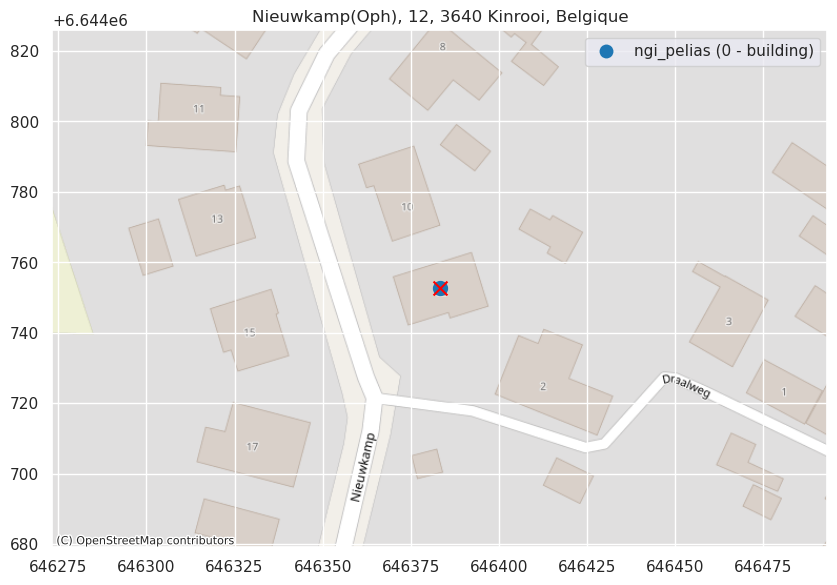

reference_key                   street housenumber postcode      city  \
6618           6665  Jan Frans Willemsstraat           3     2530  Boechout   

                                                address  \
6618  Jan Frans Willemsstraat, 3, 2530 Boechout, Bel...   

                                               location    geocoder  duration  \
6618  (3, Jan Frans Willemsstraat, 2530 Boechout, (5...  ngi_pelias   0.08069   

     precision                           point  is_in_belgium  \
6618  building  POINT (500250.867 6650101.010)           True   

                        median_point  nb_points  dist_to_median  
6618  POINT (500250.867 6650101.010)        1.0             0.0

/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


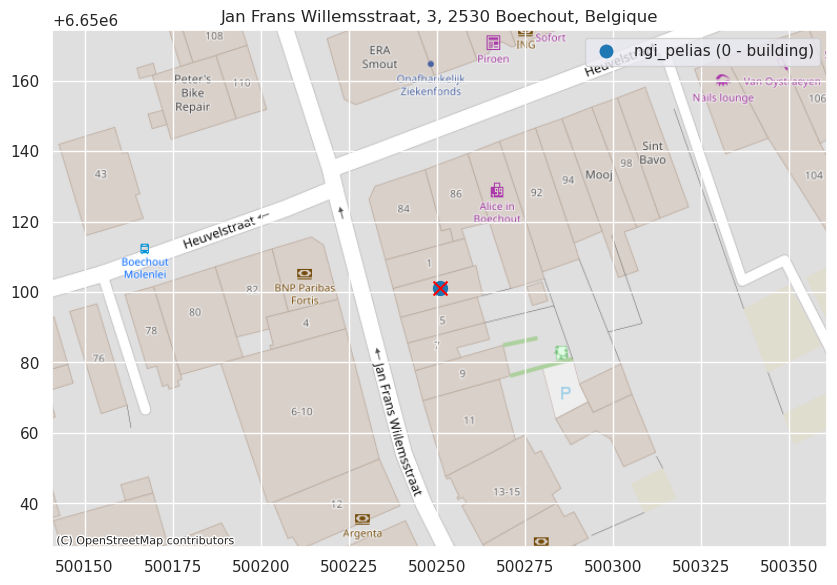

In [733]:
for a in geocoded_data.sort_values("dist_to_median", ascending=False).address.unique()[0:3]:
    #print(a)
    plot_address(geocoded_data, a)
   

## Median pertinence

How many close to median ?

In [734]:
nb_close_to_median = geocoded_data.assign(close_to_median = geocoded_data.dist_to_median < 100).groupby("address").close_to_median.sum()
nb_close_to_median

address
"Le Rosai", 5, 4052 Chaudfontaine, Belgique            1
's Boschstraat, 30, 2320 Hoogstraten, Belgique         1
's Gravendreef, 197, 9810 Nazareth, Belgique           0
's Gravenwezelsteenweg, 59, 2110 Wijnegem, Belgique    1
's Heerwillems, 14, 8630 Veurne, Belgique              1
                                                      ..
rue du Chapy,Ws, 52, 5570 Beauraing, Belgique          1
rue du Luxembourg, 70, 5570 Beauraing, Belgique        1
van Groesbeekstraat, ZN, 3511 Hasselt, Belgique        0
van Willigenstraat, 32, 3560 Lummen, Belgique          1
à la Corne du Pré, 9, 4053 Chaudfontaine, Belgique     1
Name: close_to_median, Length: 9936, dtype: int64

In [735]:
median_points = median_points.merge(nb_close_to_median.rename("nb_close_to_median").reset_index())

In [736]:
median_points.nb_close_to_median.value_counts()

1    9473
Name: nb_close_to_median, dtype: int64

In [737]:
median_points[median_points.nb_close_to_median>=2]

Empty GeoDataFrame
Columns: [address, median_point, nb_points, nb_close_to_median]
Index: []

In [738]:
# nb_close_to_median.value_counts()

In [739]:
geocoded_data = geocoded_data.merge(median_points, how="left")

In [740]:
geocoded_data.loc[geocoded_data.nb_close_to_median <2, "dist_to_median"] = pd.NA

In [741]:
geocoded_data[geocoded_data.dist_to_median.notnull()].address.nunique()

0

In [742]:
for a in nb_close_to_median[nb_close_to_median==0].iloc[0:4].index:
    if geocoded_data[geocoded_data.address == a].median_point.notnull().any():
        plot_address(geocoded_data[geocoded_data.median_point.notnull()], a)

In [743]:
geocoded_data.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_all.pkl")

## Distance to median

### Average

geocoder
ngi_pelias   NaN
Name: dist_to_median, dtype: float64

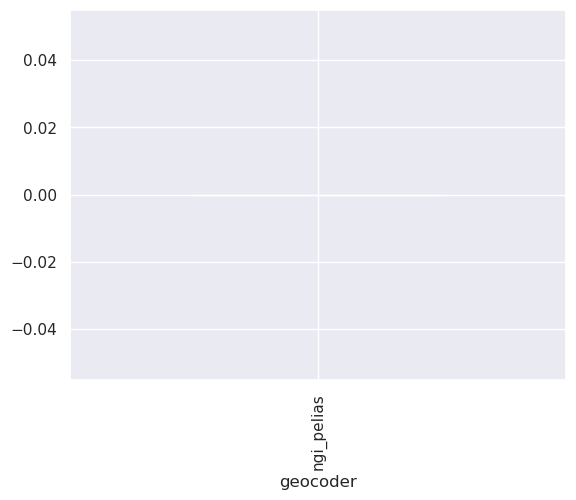

In [744]:
# d2m = geocoded_data.groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data.groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_{dataset}.png")
d2m

geocoder
ngi_pelias   NaN
Name: dist_to_median, dtype: float64

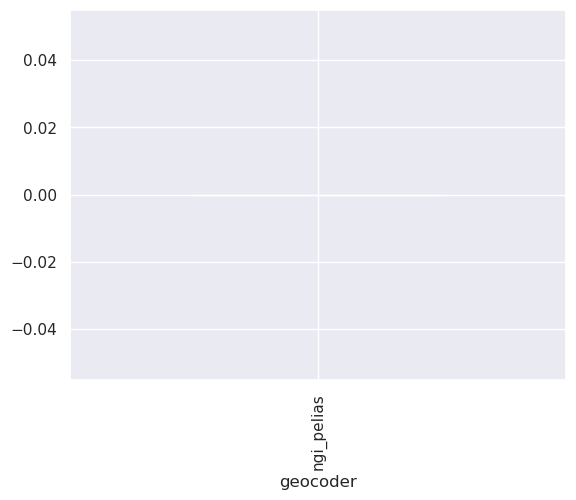

In [745]:
# skipping non reliable median

# d2m = geocoded_data[geocoded_data.is_reliable].groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data[geocoded_data.is_in_belgium].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_reliable_{dataset}.png")
d2m

### Percentiles

In [746]:
#[geocoded_data.precision=="building"]#.drop_duplicates(subset="address")
# from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import LogLocator
def dist_to_median_line_plot(d, ax=None, title=None, legend=True):
    mean = d.groupby("geocoder").dist_to_median.mean().rename("Mean")

    perc_90 = d.groupby("geocoder").dist_to_median.quantile(0.90).rename("Perc 90%")
    perc_95 = d.groupby("geocoder").dist_to_median.quantile(0.95).rename("Perc 95%")
    perc_99 = d.groupby("geocoder").dist_to_median.quantile(0.99).rename("Perc 99%")
    perc_50 = d.groupby("geocoder").dist_to_median.quantile(0.50).rename("Median")
    maxd = d.groupby("geocoder").dist_to_median.max().rename("Max")
    tops = [ d.groupby("geocoder").dist_to_median.nlargest(i).reset_index().groupby("geocoder").dist_to_median.min() for i in range(2, 50)]#.drop_index(level=1)#@@.tail(1)#.unstack()
#     mean    = mean.sort_values()
#     perc_90 = perc_90.reindex_like(mean)
#     perc_99 = perc_99.reindex_like(mean)
#     perc_50 = perc_50.reindex_like(mean)
#     maxd =    maxd.reindex_like(mean)

    mean    = mean.reindex(coders)
#     perc_90 = perc_90.reindex(coders)
    perc_95 = perc_95.reindex(coders)
    perc_50 = perc_50.reindex(coders)
    maxd =    maxd.reindex(coders)
    tops =    [t.reindex(coders) for t in tops]

    display(mean)
    ax = mean.plot(legend=legend, linestyle='dotted',marker='s', ax=ax, title=title, figsize=def_figsize)
    ax = perc_50.plot(ax=ax, legend=legend,linestyle='dotted', marker='<')
    # ax = perc_90.rename("Perc 90%").plot(ax=ax, legend=True, linestyle='dotted', marker='o')
    ax = perc_95.plot(ax=ax, legend=legend, linestyle='dotted', marker='P')
    # ax = perc_99.rename("Perc 99%").plot(ax=ax, legend=True, linestyle='dotted', marker='P')
    ax = maxd.plot(ax=ax, rot=90, legend=legend, linestyle='dotted',marker='^', logy=True)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    for t in tops:
        t.plot(ax=ax, rot=90, legend=False, linestyle="", marker='.', logy=True, c='C3', zorder=1, alpha=0.2)
    ax.set_ylabel(f"Distance to median point ({dataset})")
#     ax.set_yscale("log")
#     ax.spines['left'].set_color('red')
#     plt.tick_params(axis='y', which='minor')
#     ax.tick_params(axis='y', colors='red')
#     ax.minorticks_on()
    ax.tick_params(axis="both", direction="out", which="both", left=True, top=False)
#     ax.yaxis.set_minor_locator(LogLocator(5))
#     ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
    ax.set_xlabel(None)
    display(pd.DataFrame([mean, perc_50, perc_95, maxd]))
    


In [747]:
dist_to_median_line_plot(geocoded_data)

pdf_savefig()


geocoder
ngi_pelias   NaN
Name: Mean, dtype: float64

geocoder  ngi_pelias
Mean             NaN
Median           NaN
Perc 95%         NaN
Max              NaN

ValueError: Data has no positive values, and therefore can not be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x7f787d31e550> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

<Figure size 1000x800 with 1 Axes>

In [ ]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.apply(lambda rec: str(rec.postcode) in  str(rec.location.raw), axis=1)]

dist_to_median_line_plot(d, ax[1], "Excluding zipcode mismatches", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

In [ ]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.is_in_belgium]

dist_to_median_line_plot(d, ax[1], "Excluding outside Belgium", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

In [ ]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.precision.isin(["building", 'street'])]

dist_to_median_line_plot(d, ax[1], "Only 'building', 'street'")

pdf_savefig()


In [ ]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.precision.isin(["building", 'street']) & geocoded_data.apply(lambda rec: str(rec.postcode) in  str(rec.location.raw), axis=1)]

dist_to_median_line_plot(d, ax[1], "Excluding zipcode mismatches, \nonly 'building' and 'street'", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

In [ ]:
f, ax=plt.subplots(1,2, figsize=(16,8), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.reference_key.isin(geocoded_data[geocoded_data.geocoder=="jcd"].reference_key)]

dist_to_median_line_plot(d, ax[1], "Only addresses geocoded by jcd", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

# Geocoder outsiders

In [ ]:
gcd="jcd"

In [ ]:
x = geocoded_data[geocoded_data.geocoder==gcd].sort_values("dist_to_median")
x

In [ ]:
for addr in x.iloc[-10:].address:
    
    plot_address(geocoded_data, addr)

In [ ]:

# plot_address(geocoded_data, geocoded_data.loc[7930].address)

In [ ]:
pdf.close()

# Tests

In [ ]:
geocoded_data[geocoded_data.geocoder=="ngi_pelias"].precision.value_counts()

In [ ]:
# geocoded_data[(geocoded_data.geocoder=="ngi_pelias") & (geocoded_data.precision != "building")].sort_values(["precision", "postcode"]).iloc[0:60]

In [ ]:
geocoders["pelias"].geocode({'address': f'A VIBON DJU(DU VIEUX BON DIEU',
   'postalcode': '4350',
   'locality': 'remicourt'}).raw
#     print res["properties"][""]

In [ ]:
geocoders["ngi_pelias"].geocode({'street': f'Rue Marconi',
                                 'housenumber':'113',
   'postcode': '1190',
   'city': 'forest'}).raw
#     print res["properties"][""]

In [ ]:
# geocoders["pelias"].geocode("Rue Auguste Heen, 17, 1190").raw

In [ ]:
# geocoded_data[geocoded_data.geocoder=="ngi_pelias"].location.apply(lambda rec: rec.raw["properties"]["match_type"]).value_counts()

In [ ]:
# geocoded_data[(geocoded_data.geocoder=="ngi_pelias") & (geocoded_data.precision=="street")].location.apply(lambda rec: rec.raw["properties"]["match_type"]).value_counts()

In [ ]:
pelias_res = geocoded_data[(geocoded_data.geocoder=="ngi_pelias")]

pelias_res[pelias_res.precision!="building"].sort_values(["precision", "postcode"])#.iloc[0:60]

In [ ]:
# pelias_res.loc[291].location.raw

In [ ]:
pelias_res[pelias_res.location.apply(lambda rec: rec.raw["properties"]["match_type"]== "fallback" and rec.raw["properties"]["accuracy"]== "point") ]

In [ ]:
pelias_res[pelias_res.location.apply(lambda rec: rec.raw["properties"]["accuracy"]== "point") & (pelias_res.precision!="building") ]

In [ ]:
pelias_res.loc[52].location.raw

In [ ]:
data#set

In [ ]:
k = 432

d =data.loc[k]
display(d)
d = d.str.replace("(L.L)", "", regex=False)
display(d)

r = geocoders["ngi_pelias"].geocode(d.to_dict(), exactly_one=False)#[0].raw

r

In [ ]:
r[0].raw

In [ ]:
data.loc[k]

In [751]:
geocoded_data.location.iloc[1].raw["properties"]

{'id': 'bebru_fr_164117',
 'gid': 'be-bru:address:bebru_fr_164117',
 'layer': 'address',
 'source': 'be-bru',
 'source_id': 'bebru_fr_164117',
 'country_code': 'BE',
 'name': '47, Boulevard du Régent, 1000 Bruxelles',
 'housenumber': '47',
 'street': 'Boulevard du Régent',
 'postalcode': '1000',
 'confidence': 1,
 'match_type': 'exact',
 'accuracy': 'point',
 'country': 'Belgium',
 'country_gid': 'whosonfirst:country:85632997',
 'country_a': 'BEL',
 'region': 'Brussels',
 'region_gid': 'whosonfirst:region:85681713',
 'region_a': 'BU',
 'neighbourhood': 'Sint-Joost-ten-Noode',
 'neighbourhood_gid': 'whosonfirst:neighbourhood:85801909',
 'label': '47, Boulevard du Régent, 1000 Bruxelles, BU, Belgium',
 'addendum': {'best': {'best_id': 164117,
   'name_fr': '47, Boulevard du Régent, 1000 Bruxelles',
   'name_nl': '47, Regentlaan, 1000 Brussel',
   'streetname_fr': 'Boulevard du Régent',
   'streetname_nl': 'Regentlaan',
   'municipality_name_fr': 'Bruxelles',
   'municipality_name_nl': 'B

In [971]:
geocoded_data["pelias_street"] = geocoded_data.location.apply(lambda rec: rec.raw["properties"]["street"] if rec and "properties" in rec.raw and "street" in rec.raw["properties"] else pd.NA)
geocoded_data["pelias_postalcode"] = geocoded_data.location.apply(lambda rec: rec.raw["properties"]["postalcode"] if rec and "properties" in rec.raw and "postalcode" in rec.raw["properties"] else pd.NA)

for f in 'municipality_name_fr', 'municipality_name_nl', 'municipality_name_de',  'postname_fr', 'postname_nl',  'postname_fr':
    geocoded_data["pelias_"+f] = geocoded_data.location.apply(lambda rec: rec.raw["properties"]["addendum"]["best"][f] if rec and "addendum" in rec.raw["properties"] and "best" in rec.raw["properties"]["addendum"] and f in rec.raw["properties"]["addendum"]["best"] else pd.NA)
    

In [974]:
geocoded_data.drop(["reference_key", "address", "location", "geocoder", "duration", "is_in_belgium", "median_point", "nb_points", "dist_to_median", "nb_close_to_median"], axis=1, errors="ignore").to_csv("output/pelias_rep.csv")

In [973]:
# geocoded_data[geocoded_data.pelias_postname_fr.notnull()]
dataset

'rep_10000'